# Hadoop project



https://www.kaggle.com/code/berkanacar/home-credit-default-risk-production-level


In [ ]:
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None # показываем все колонки

import re
import zipfile
import os
import gc
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')


## Flags

In [ ]:
full_data_flag = True
split_flag = True
imputer_flag = True
imbalance_flag = True
ext_source_flag = False
scaling = True
feature_selection_flag = True

**Пояснительния**

full_data_flag = True

этот флаг ответственнен за загрузке всех данных или нет
есть 2 варианта:
1) загружаются все данные то есть все таблицы(их 8) и они обьединяются после этого получается 538 колонок
2) в этом варианте будет только 121 колонки и все таблицы кроме application_train and application_test не будут загружать это как раз причина почему получется меньше колонок так как мы не будем обьединять данные, этот вариант никак не влияет на другой все точно так же будет запускаться без ошибок но результаты в конце будут похуже зато быстрее загрузятся данные примерно на 2минуты


imputer_flag = True

imbalance_flag = False

split_flag = True

ext_source_flag = False

# Data preparation

## Read files

In [ ]:
def reduce_mem_usage(df, verbose=True):
    """ Это функция меняет data types of columns на более экономные по отношению к памяти"""
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def get_balance_data(default_dir):
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }

    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }

    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }

    pos_bal = pd.read_csv(os.path.join(default_dir,'POS_CASH_balance.csv'), dtype=pos_dtype)
    install = pd.read_csv(os.path.join(default_dir,'installments_payments.csv'), dtype=install_dtype)
    card_bal = pd.read_csv(os.path.join(default_dir, 'credit_card_balance.csv'), dtype=card_dtype)

    return pos_bal, install, card_bal

In [ ]:
# код для подключение файлов в гугл колаб
list_of_files = os.listdir()
if 'data' not in list_of_files:
  drive.mount('/content/drive')
  zip_file = '/content/drive/MyDrive/csv files for diploma/home-credit-default-risk.zip'
  os.makedirs('/content/data')
  z = zipfile.ZipFile(zip_file,'r')
  z.extractall('data/')

In [ ]:
# загружаем наши данные в оптимизированном формате
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')

app_train = reduce_mem_usage(app_train)
app_test = reduce_mem_usage(app_test)

apps = pd.concat([app_train, app_test])
# desc = pd.read_csv('data/HomeCredit_columns_description.csv', encoding = 'ISO-8859-1')

if full_data_flag:
    # загружаем все данные
    prev = pd.read_csv('data/previous_application.csv')
    bureau = pd.read_csv('data/bureau.csv')
    bureau_bal = pd.read_csv('data/bureau_balance.csv')
    pos_bal, install, card_bal = get_balance_data('data/')

    # уменьшаем обьем данных
    prev = reduce_mem_usage(prev)
    bureau = reduce_mem_usage(bureau)
    bureau_bal = reduce_mem_usage(bureau_bal)

Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


## Data collection

### Functions

In [ ]:
# apps
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE_X FEATURE
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())

    # AMT_CREDIT
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']

    # AMT_INCOME_TOTAL
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']

    # DAYS_BIRTH, DAYS_EMPLOYED
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']

    # мною добавленный сюда код
    apps['DAYS_EMPLOYED_PERC'] = apps['DAYS_EMPLOYED'] / apps['DAYS_BIRTH']
    apps['INCOME_CREDIT_PERC'] = apps['AMT_INCOME_TOTAL'] / apps['AMT_CREDIT']
    apps['INCOME_PER_PERSON'] = apps['AMT_INCOME_TOTAL'] / apps['CNT_FAM_MEMBERS']
    apps['ANNUITY_INCOME_PERC'] = apps['AMT_ANNUITY'] / apps['AMT_INCOME_TOTAL']
    apps['PAYMENT_RATE'] = apps['AMT_ANNUITY'] / apps['AMT_CREDIT']

    return apps

# prev
def get_prev_days365_agg(prev):
    """
    DAYS_DESCISION means How many days have been take since the previous credit application made.
    Somehow this feature is important.
    """
    cond_days365 = prev['DAYS_DECISION'] > -365
    prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'],
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],

      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'],
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    # multi index
    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg

def get_prev_refused_appr_agg(prev):
    """
    PREV_APPROVED_COUNT : Credit application approved count
    PREV_REFUSED_COUNT :  Credit application refused count
    """
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    # unstack()
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

    # rename column
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]

    # NaN
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

    return prev_refused_appr_agg

def get_prev_amt_agg(prev):
    """
    feature engineering for the previous credit appliction
    """

    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'],
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],

      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'],
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg

def get_prev_processed(prev):
    """
    feature engineering
    for previouse application credit history
    """
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    # Data Cleansing
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # 1.Calculate the interest rate
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)

    # prev_amt_agg
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR APPROVED_COUNT REFUSED_COUNT
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' drop
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)

    return prev_agg

# bureau_bal SK_ID_CURR MONTHS_BALANCE aggregation
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR Group by bureau SK_ID_CURR
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')

    # STATUS 120
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR MONTHS_BALANCE aggregation
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # SK_ID_CURR reset_index()
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg

# BUREAU DAYS_CREDIT -750
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],

        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()

    return bureau_days750_agg

def get_bureau_active_agg(bureau):
    '''
    Bureau CREDIT_ACTIVE='Active' filtering
    SK_ID_CURR aggregation
    '''
    # CREDIT_ACTIVE='Active' filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],

      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_active_agg = bureau_active_agg.reset_index()
    #print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg


def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']

    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)

    return bureau

# bureau aggregation
def get_bureau_agg(bureau, bureau_bal):

    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)

    # bureau_day_amt_agg bureau_active_agg
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS ACTIVE IS_DPD RATIO

    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']

    # bureau_agg bureau_bal_agg
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left')

    #print('bureau_agg shape:', bureau_agg.shape)

    return bureau_agg

# pos_bal
def get_pos_bal_agg(pos_bal):
    # (SK_DPD) 0 , 0~ 100 , 100
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 0~ 120 120
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'mean', 'max'],
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],

        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)

    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]

    # MONTHS_BALANCE (20)
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'mean', 'max'],
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],

        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)

    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')

    # SK_ID_CURR reset_index()
    pos_bal_agg = pos_bal_agg.reset_index()


    return pos_bal_agg

# install
def get_install_agg(install):
    # DPD
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 30~ 120 100
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'],
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]


    # (DAYS_ENTRY_PAYMENT) (1)
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'],
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']
    }

    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]

    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()

    return install_agg

# card_bal
def get_card_bal_agg(card_bal):
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],

        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()

    # MONTHS_BALANCE (3)
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()

    return card_bal_agg

### Aggregating

In [ ]:
# apps prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
    """
    Description :
    1.Data preparation , aggregation
    2.produce the finalized result
    """
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    pos_bal_agg = get_pos_bal_agg(pos_bal)
    install_agg = get_install_agg(install)
    card_bal_agg = get_card_bal_agg(card_bal)
    print('-----------------Count of features by tables-----------------')
    print('apps_processed shape:', apps_all.shape)
    print('prev_agg shape:', prev_agg.shape )
    print('bureau_agg shape:', bureau_agg.shape)
    print('pos_bal_agg shape:', pos_bal_agg.shape)
    print('install_agg shape:', install_agg.shape)
    print('card_bal_agg shape:', card_bal_agg.shape)


    # Join with apps_all
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')

    print('df after merge with all shape:', apps_all.shape)
    return apps_all

In [ ]:
print('-----------------Files shapes----------------------')
print(f"app_train.shape = {app_train.shape}")
print(f"app_test.shape = {app_test.shape}")
print(f"apps.shape = {apps.shape}")
if full_data_flag:
    print(f"prev.shape = {prev.shape}")
    print(f"bureau.shape = {bureau.shape}")
    print(f"bureau_bal.shape = {bureau_bal.shape}")
    print(f"pos_bal.shape = {pos_bal.shape}")
    print(f"install.shape = {install.shape}")
    print(f"card_bal.shape = {card_bal.shape}")
print()



if full_data_flag:
    df = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)

    del prev,bureau,bureau_bal,pos_bal,install,card_bal,apps,app_train,app_test
    gc.collect()
else:
    df = apps.copy()

    print('df shape:', df.shape)

    del apps,app_train,app_test
    gc.collect()


# разделяем application_train and application_test
real_test = df[df['TARGET'].isnull()]
real_test.drop(columns=['TARGET'], inplace=True)
real_test.reset_index(drop=True, inplace=True)

df = df[df['TARGET'].notnull()]
df.reset_index(drop=True, inplace=True)

print()
print('-----------------Data after extract real_test---------------------------------')
print(f"df.shape = {df.shape}")
print(f"real_test.shape = {real_test.shape}")

-----------------Files shapes----------------------
app_train.shape = (307511, 122)
app_test.shape = (48744, 121)
apps.shape = (356255, 122)
prev.shape = (1670214, 37)
bureau.shape = (1716428, 17)
bureau_bal.shape = (27299925, 3)
pos_bal.shape = (10001358, 8)
install.shape = (13605401, 8)
card_bal.shape = (3840312, 23)

-----------------Count of features by tables-----------------
apps_processed shape: (356255, 140)
prev_agg shape: (338857, 80)
bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45)
install_agg shape: (339587, 59)
card_bal_agg shape: (103558, 70)
df after merge with all shape: (356255, 539)

-----------------Data after extract real_test---------------------------------
df.shape = (307511, 539)
real_test.shape = (48744, 538)


In [ ]:
real_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_EMPLOYED_RATIO,APPS_INCOME_BIRTH_RATIO,APPS_CAR_BIRTH_RATIO,APPS_CAR_EMPLOYED_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_D365_SK_ID_CURR_COUNT,PREV_D365_AMT_CREDIT_MEAN,PREV_D365_AMT_CREDIT_MAX,PREV_D365_AMT_CREDIT_SUM,PREV_D365_AMT_ANNUITY_MEAN,PREV_D365_AMT_ANNUITY_MAX,PREV_D365_AMT_ANNUITY_SUM,PREV_D365_AMT_APPLICATION_MEAN,PREV_D365_AMT_APPLICATION_MAX,PREV_D365_AMT_APPLICATION_SUM,PREV_D365_AMT_DOWN_PAYMENT_MEAN,PREV_D365_AMT_DOWN_PAYMENT_MAX,PREV_D365_AMT_DOWN_PAYMENT_SUM,PREV_D365_AMT_GOODS_

## Data processing

### Drop useless columns

In [ ]:
def drop_special_and_unwanted_columns(dataframe,special=False):
    result = ''

    for_drop = ['SK_ID_CURR']
    if special:
        for_drop.extend(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APPS_EXT_SOURCE_MEAN', 'APPS_EXT_SOURCE_STD'])


    temp = dataframe.filter(for_drop)
    result = dataframe.drop(temp, axis=1)


    print('-----------------Deleting unwanted columns---------------------------------')
    print(f"df before - {dataframe.shape}")
    print(f"df after - {result.shape}")
    print(f"count of deleted - {len(temp.columns)}")
    return result


# сохраняем потому что понадобится
submit = real_test[['SK_ID_CURR']]

df = drop_special_and_unwanted_columns(df, special=ext_source_flag)

-----------------Deleting unwanted columns---------------------------------
df before - (307511, 539)
df after - (307511, 538)
count of deleted - 1


### Catching anomalies

In [ ]:
# XNA это хз что такое так что аномалия и убираем ее

print(f"Before:")
print(f"df - {df.shape}")
df = df[df['CODE_GENDER']!='XNA']
df = df[df['ORGANIZATION_TYPE']!='XNA']

# это явно не outliers это прям аномалия
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

# Max income in test is 4M; train has a 117M value
df = df[df['AMT_INCOME_TOTAL'] < 20000000]

df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

print(f"After:")
print(f"df - {df.shape}")

Before:
df - (307511, 538)
After:
df - (252132, 538)


### Nan columns

In [ ]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values_table(df).head()

Your selected dataframe has 538 columns.
There are 477 columns that have missing values.


,Missing Values,% of Total Values
BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MIN_x,250920,99.5
BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MEAN_x,250920,99.5
BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MAX_x,250920,99.5
BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MEAN_x,250912,99.5
BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MAX_x,250912,99.5


In [ ]:
def delete_columns_by_Nan_percentage(dataframe, perc=50.0):
    """perc - это нижнее значение процента, то есть будут удаленны все колонки в которых count of nan больше чем 10%
    """
    result = ''

    shape1 = dataframe.shape
    min_count =  int(((100-perc)/100)*shape1[0] + 1)
    result = dataframe.dropna(axis=1, thresh=min_count)
    shape2 = result.shape

    print(f"Before")
    print(f"df.shape = {shape1}")
    print()
    print(f"After")
    print(f"df.shape = {shape2}")
    print()
    print(f"count of deleted columns = {shape1[1]-shape2[1]}")

    return result

# Delete columns containing either 70% or more than 70% NaN Values
df = delete_columns_by_Nan_percentage(df,perc = 10)

Before
df.shape = (252132, 538)

After
df.shape = (252132, 162)

count of deleted columns = 376


In [ ]:
real_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_EMPLOYED_RATIO,APPS_INCOME_BIRTH_RATIO,APPS_CAR_BIRTH_RATIO,APPS_CAR_EMPLOYED_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_D365_SK_ID_CURR_COUNT,PREV_D365_AMT_CREDIT_MEAN,PREV_D365_AMT_CREDIT_MAX,PREV_D365_AMT_CREDIT_SUM,PREV_D365_AMT_ANNUITY_MEAN,PREV_D365_AMT_ANNUITY_MAX,PREV_D365_AMT_ANNUITY_SUM,PREV_D365_AMT_APPLICATION_MEAN,PREV_D365_AMT_APPLICATION_MAX,PREV_D365_AMT_APPLICATION_SUM,PREV_D365_AMT_DOWN_PAYMENT_MEAN,PREV_D365_AMT_DOWN_PAYMENT_MAX,PREV_D365_AMT_DOWN_PAYMENT_SUM,PREV_D365_AMT_GOODS_

In [ ]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_EMPLOYED_RATIO,APPS_INCOME_BIRTH_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_SUM,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM,INS_SK_ID_CURR_COUNT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_SUM,INS_AMT_DIFF_MEAN,INS_AMT_DIFF_MIN,INS_AMT_DIFF_MAX,INS_AMT_DIFF_SUM,INS_AMT_RATIO_MEAN,INS_AMT_RATIO_MAX,INS_SK_DPD_MEAN,INS_SK_DPD_MIN,INS_SK_DPD_MAX,INS_INS_IS_DPD_MEAN,INS_INS_IS_DPD_SUM,INS_INS_IS_DPD_UNDER_120_MEAN,INS_INS_IS_DPD_UNDER_120_SUM,INS_INS_IS_DPD_OVER_120_MEAN,INS_INS_IS_DPD_OVER_120_SUM
0,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262939,2.0,2.0,2.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.161743,0.092041,0.060749,0.863262,0.121978,2.007889,1.733333,202500.0,0.067329,-317.896389,-21.403658,0.067329,0.498036,202500.0,0.121978,0.060749,1.0,179055.00,179055.0,179055.0,9251.775391,9251.775391,9251.775391,179055.00,179055.0,1790

In [ ]:
missing_values_table(df).head()

Your selected dataframe has 162 columns.
There are 101 columns that have missing values.


,Missing Values,% of Total Values
POS_CNT_INSTALMENT_MEAN,15222,6.0
POS_CNT_INSTALMENT_MIN,15222,6.0
POS_CNT_INSTALMENT_FUTURE_MEAN,15222,6.0
POS_CNT_INSTALMENT_FUTURE_MAX,15222,6.0
POS_CNT_INSTALMENT_FUTURE_MIN,15222,6.0


### inf columns

In [ ]:
def delete_columns_with_inf_values(dataframe):
    result = ''
    # df.isin([np.inf, -np.inf])
    num_df = dataframe.select_dtypes(include=np.number)
    col_names = num_df.columns.to_series()[np.isinf(num_df).any()]


    count_inf_by_columns = []
    for i in col_names:
        count_inf_by_columns.append(f"{i} - {np.isinf(num_df[i]).values.sum()}")

    shape1 = dataframe.shape

    result = dataframe.drop(columns=col_names,axis=1)
    shape2 = result.shape

    print(f"Before:")
    print(f"df.shape = {shape1}")
    print()
    print(f"After:")
    print(f"df.shape = {shape2}")
    print()
    print(f"count of deleted columns = {shape1[1]-shape2[1]}")


    print()
    print(f"count inf values by columns:")
    for i in count_inf_by_columns:
      print(i)

    print()

    return result

df = delete_columns_with_inf_values(df)
df.head()

Before:
df.shape = (252132, 162)

After:
df.shape = (252132, 157)

count of deleted columns = 5

count inf values by columns:
APPS_INCOME_EMPLOYED_RATIO - 2
PREV_PREV_CREDIT_APPL_RATIO_MAX - 36582
PREV_PREV_GOODS_APPL_RATIO_MEAN - 2
PREV_PREV_GOODS_APPL_RATIO_MAX - 9
PREV_PREV_INTERESTS_RATE_MAX - 1802



,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_BIRTH_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_SUM,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM,INS_SK_ID_CURR_COUNT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_SUM,INS_AMT_DIFF_MEAN,INS_AMT_DIFF_MIN,INS_AMT_DIFF_MAX,INS_AMT_DIFF_SUM,INS_AMT_RATIO_MEAN,INS_AMT_RATIO_MAX,INS_SK_DPD_MEAN,INS_SK_DPD_MIN,INS_SK_DPD_MAX,INS_INS_IS_DPD_MEAN,INS_INS_IS_DPD_SUM,INS_INS_IS_DPD_UNDER_120_MEAN,INS_INS_IS_DPD_UNDER_120_SUM,INS_INS_IS_DPD_OVER_120_MEAN,INS_INS_IS_DPD_OVER_120_SUM
0,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262939,2.0,2.0,2.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.161743,0.092041,0.060749,0.863262,0.121978,2.007889,1.733333,202500.0,0.067329,-21.403658,0.067329,0.498036,202500.0,0.121978,0.060749,1.0,179055.00,179055.0,179055.0,9251.775391,9251.775391,9251.775391,179055.00,179055.0,179055.00,0.00000,179055.000,179055.0,179055.00,-606.0,-606.0,-606.000000,24.000000,24.0,0.000000,0.0,0.00000,0.0,0.0,0.0,150.0,0.000000,1.000000,19.0,-19.0,-10.000000

In [ ]:
real_test.shape

(48744, 538)

In [ ]:
df.shape

(252132, 157)

In [ ]:
df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_BIRTH_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_SUM,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM,INS_SK_ID_CURR_COUNT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_SUM,INS_AMT_DIFF_MEAN,INS_AMT_DIFF_MIN,INS_AMT_DIFF_MAX,INS_AMT_DIFF_SUM,INS_AMT_RATIO_MEAN,INS_AMT_RATIO_MAX,INS_SK_DPD_MEAN,INS_SK_DPD_MIN,INS_SK_DPD_MAX,INS_INS_IS_DPD_MEAN,INS_INS_IS_DPD_SUM,INS_INS_IS_DPD_UNDER_120_MEAN,INS_INS_IS_DPD_UNDER_120_SUM,INS_INS_IS_DPD_OVER_120_MEAN,INS_INS_IS_DPD_OVER_120_SUM
0,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262939,2.0,2.0,2.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.161743,0.092041,0.060749,0.863262,0.121978,2.007889,1.733333,202500.0,0.067329,-21.403658,0.067329,0.498036,202500.0,0.121978,0.060749,1.0,179055.000,179055.0,179055.0,9251.775391,9251.775391,9251.775391,179055.000,179055.0,179055.00,0.00000,179055.000,179055.0,179055.00,-606.0,-606.0,-606.000000,24.000000,24.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,150.0,0.000000,1.000000,19.0,-19.0,-10

### Align df and real_test

In [ ]:
# Делаем так что бы real_test and df имели одинаковые колонки
print('--------------before Align-------------')
print('df shape: ', df.shape)
print('real_test shape: ', real_test.shape)

train_labels = df['TARGET']
df, real_test = df.align(real_test, join = 'inner', axis = 1)
df['TARGET'] = train_labels

print('--------------after Align-------------')
print('df shape: ', df.shape)
print('real_test shape: ', real_test.shape)

--------------before Align-------------
df shape:  (252132, 157)
real_test shape:  (48744, 538)
--------------after Align-------------
df shape:  (252132, 157)
real_test shape:  (48744, 156)


## Split(train test)

In [ ]:
from sklearn.model_selection import train_test_split

if split_flag:
    x = df.drop('TARGET', axis=1)
    y = df['TARGET']

    print('-------------before train_test_split-------------')
    print(f"df.shape - {df.shape}")
    print(f"x.shape - {x.shape}")
    print(f"y.shape - {y.shape}")
    print()

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=666)
    del x,y,df
    gc.collect()

    print('--------------after train_test_split-------------')
    print(f"x_train.shape - {x_train.shape}")
    print(f"y_train.shape - {y_train.shape}")
    print(f"x_test.shape - {x_test.shape}")
    print(f"y_test.shape - {y_test.shape}")
else:

    print('-------------before non-train_test_split-------------')
    print(f"df.shape - {df.shape}")
    print()

    x_train = df.drop('TARGET', axis=1)
    y_train = df['TARGET']
    del df
    gc.collect()

    print('--------------after non-train_test_split-------------')
    print(f"x_train.shape - {x_train.shape}")
    print(f"y_train.shape - {y_train.shape}")


-------------before train_test_split-------------
df.shape - (252132, 157)
x.shape - (252132, 156)
y.shape - (252132,)

--------------after train_test_split-------------
x_train.shape - (201705, 156)
y_train.shape - (201705,)
x_test.shape - (50427, 156)
y_test.shape - (50427,)


In [ ]:
x_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_BIRTH_RATIO,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_SUM,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM,INS_SK_ID_CURR_COUNT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_SUM,INS_AMT_DIFF_MEAN,INS_AMT_DIFF_MIN,INS_AMT_DIFF_MAX,INS_AMT_DIFF_SUM,INS_AMT_RATIO_MEAN,INS_AMT_RATIO_MAX,INS_SK_DPD_MEAN,INS_SK_DPD_MIN,INS_SK_DPD_MAX,INS_INS_IS_DPD_MEAN,INS_INS_IS_DPD_SUM,INS_INS_IS_DPD_UNDER_120_MEAN,INS_INS_IS_DPD_UNDER_120_SUM,INS_INS_IS_DPD_OVER_120_MEAN,INS_INS_IS_DPD_OVER_120_SUM
276797,Cash loans,F,N,Y,1,90000.0,168102.0,16753.5,148500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.016617,-11612,-3655,-1413.0,-3037,1,1,0,1,1,0,3.0,2,2,THURSDAY,13,0,0,0,0,0,0,Other,0.515625,1.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.558594,0.137207,0.099663,0.883392,0.186150,1.867800,1.650000,30000.0,0.314761,-7.750603,0.314761,0.535389,30000.0,0.186150,0.099663,9.0,6.325484e+04,104476.5,5.692936e+05,6410.830078,10659.644531,57697.468750,63030.839844,94495.5,5.672776e+05,25294.500000,6.303084e+04,94495.5,5.672776e+05,-2305.0,-243.0,-1091.777778,11.111111,100.0,-223.999786,7650.000000,-2015.998047,0.0,0.0,0.0,300.0,0.111111,0.888889,93.0,-96.0,-42.720

In [ ]:
y_train.head()

276797    0.0
301549    0.0
92454     0.0
282023    0.0
116240    0.0
Name: TARGET, dtype: float64

## Encoding

### functions

In [ ]:
def one_hot_label_encoding(dataframe):
    from sklearn.preprocessing import LabelEncoder
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0

    result = ''
    # Iterate through the columns
    for col in dataframe:
        if dataframe[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(dataframe[col].unique())) <= 2:
                # Train on the training data
                le.fit(dataframe[col])
                # Transform both training and testing data
                dataframe[col] = le.transform(dataframe[col])

                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)

    # one-hot encoding of categorical variables
    result = pd.get_dummies(dataframe, dummy_na=True)



    result.rename(columns = lambda x:re.sub('[:,./-]+', '', x), inplace=True)
    result.rename(columns = lambda x:re.sub(' +', ' ', x),inplace=True)
    result.rename(columns = lambda x:re.sub('_+', '_', x),inplace=True)
    result.rename(columns = lambda x:re.sub(' +', '_', x),inplace=True)
    # result.replace(' ','_', regex=True, inplace=True)


    print('df Features shape: ', result.shape)

    return result

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]

    return apps_all

# df = get_apps_all_encoded(df)

In [ ]:
# print('--------------before--------------')
# print(f"x_train - {x_train.shape}")
# if split_flag:
#     print(f"x_test - {x_test.shape}")
# print(f"real_test - {real_test.shape}")
# print()

# x_train = get_apps_all_encoded(x_train)
# real_test = get_apps_all_encoded(real_test)

# if split_flag:
#     x_test = get_apps_all_encoded(x_test)

# print()
# print('--------------after--------------')
# print(f"x_train - {x_train.shape}")
# if split_flag:
#     print(f"x_test - {x_test.shape}")
# print(f"real_test - {real_test.shape}")

In [ ]:
print('--------------before--------------')
print(f"x_train - {x_train.shape}")
if split_flag:
    print(f"x_test - {x_test.shape}")
print(f"real_test - {real_test.shape}")
print()

x_train = one_hot_label_encoding(x_train)
real_test = one_hot_label_encoding(real_test)

if split_flag:
    x_test = one_hot_label_encoding(x_test)

print()
print('--------------after--------------')
print(f"x_train - {x_train.shape}")
if split_flag:
    print(f"x_test - {x_test.shape}")
print(f"real_test - {real_test.shape}")

--------------before--------------
x_train - (201705, 156)
x_test - (50427, 156)
real_test - (48744, 156)

4 columns were label encoded.
df Features shape:  (201705, 251)
4 columns were label encoded.
df Features shape:  (48744, 251)
4 columns were label encoded.
df Features shape:  (50427, 249)

--------------after--------------
x_train - (201705, 251)
x_test - (50427, 249)
real_test - (48744, 251)


### Align

In [ ]:
print('--------------before--------------')
print(f"x_train - {x_train.shape}")
if split_flag:
    print(f"x_test - {x_test.shape}")
print(f"real_test - {real_test.shape}")
print()


x_train, real_test = x_train.align(real_test, join = 'inner', axis = 1)

if split_flag:
    x_train, x_test = x_train.align(x_test, join = 'inner', axis = 1)
    x_test, real_test = x_test.align(real_test, join = 'inner', axis = 1)


print('--------------after--------------')
print(f"x_train - {x_train.shape}")
if split_flag:
    print(f"x_test - {x_test.shape}")
print(f"real_test - {real_test.shape}")
print()

--------------before--------------
x_train - (201705, 251)
x_test - (50427, 249)
real_test - (48744, 251)

--------------after--------------
x_train - (201705, 248)
x_test - (50427, 248)
real_test - (48744, 248)



## Missing values

### show problem

In [ ]:
missing_values_table(x_train).head()

Your selected dataframe has 248 columns.
There are 96 columns that have missing values.


,Missing Values,% of Total Values
POS_CNT_INSTALMENT_MEAN,12207,6.1
POS_CNT_INSTALMENT_MIN,12207,6.1
POS_CNT_INSTALMENT_FUTURE_MEAN,12207,6.1
POS_CNT_INSTALMENT_FUTURE_MAX,12207,6.1
POS_CNT_INSTALMENT_FUTURE_MIN,12207,6.1


### SimpleImputer



In [ ]:
def dropna_in_x_and_corresponding_indexs_in_y(x,y,text):
    """У нас есть x_train к примеру к нему мы хотим применить dropna но нужно удалить
    соответствующие индексы так и у y_train чтобы данные остались целостными это функция это и делает"""
    result_x = ''
    result_y = ''
    print(f'-----------{text}-----------')
    print('before:')
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")

    idx_of_non_droped = x.dropna().index
    idx_of_droped = y[~y.index.isin(idx_of_non_droped)].index.to_list()

    result_x = x.dropna()
    result_y = y.drop(idx_of_droped) # deleting rows by index

    print()
    print('after:')
    print(f"x.shape = {result_x.shape}")
    print(f"y.shape = {result_y.shape}")
    print()
    print(f"whether the indices are the same - {result_x.index.equals(result_y.index)}")

    return result_x,result_y

In [ ]:
print(f"imputer_flag = {imputer_flag}")

if imputer_flag:
    from sklearn.impute import SimpleImputer

    # Median imputation of missing values
    imputer = SimpleImputer(missing_values = np.nan, strategy='median')
    # Fit on the training data
    imputer.fit(x_train)
    # Transform both training and testing data

    x_train[:] = imputer.transform(x_train)

    real_test[:] = imputer.transform(real_test)
    if split_flag:
        x_test[:] = imputer.transform(x_test)
else:
    x_train, y_train = dropna_in_x_and_corresponding_indexs_in_y(x_train,y_train,'x_train and y_train')

    print('\n')
    if split_flag:
        x_test, y_test = dropna_in_x_and_corresponding_indexs_in_y(x_test,y_test,'x_test and y_test')



imputer_flag = True


In [ ]:
missing_values_table(x_train).head()

Your selected dataframe has 248 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
if split_flag:
    missing_values_table(x_test).head()

Your selected dataframe has 248 columns.
There are 0 columns that have missing values.


## Imbalance

### show problem

In [ ]:
# functions
def print_imbalance(x,y,title="",convert=False):
    """
    ты это читаешь? зачем иди своей дорогой путник
    """
    print("\033[1m"+title+"\033[0m")
    if convert:
        target_count = x.join(y)[y.name].apply( lambda x: 'No' if(x == 0) else 'Yes').value_counts()
    else:
        target_count = x.join(y)[y.name].apply( lambda x: '0' if(x == 0) else '1').value_counts()

    print(f'Number of rows:', target_count[1]+target_count[0])
    print(f'Number with {y.name}:', target_count[1])
    print(f'Number without {y.name}:', target_count[0])
    print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
    print(f'Percent: {round(target_count[0] / (target_count[1]+target_count[0]), 3)*100}%',
          ':' ,f'{round(target_count[1] / (target_count[1]+target_count[0]), 3)*100}%')

    target_count.plot(kind='bar', title=y.name);
    plt.show()

Train before resampling
Number of rows: 201705
Number with TARGET: 17474
Number without TARGET: 184231
Proportion: 10.54 : 1
Percent: 91.3% : 8.7%


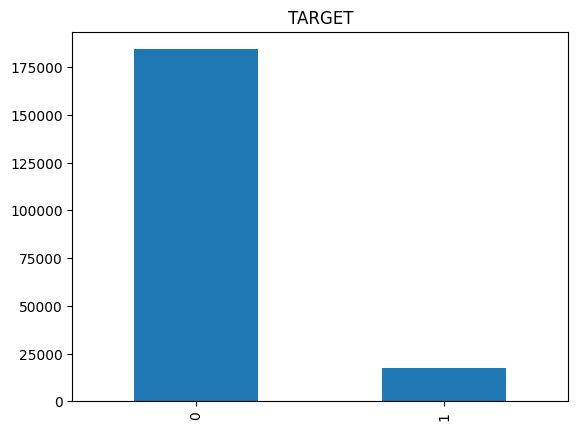

In [ ]:
if split_flag:
    print_imbalance(x_train,y_train,"Train before resampling",convert=False)
else:
    print_imbalance(x_train,y_train,"Imbalance в данных",convert=False)

Test before resampling
Number of rows: 50427
Number with TARGET: 4360
Number without TARGET: 46067
Proportion: 10.57 : 1
Percent: 91.4% : 8.6%


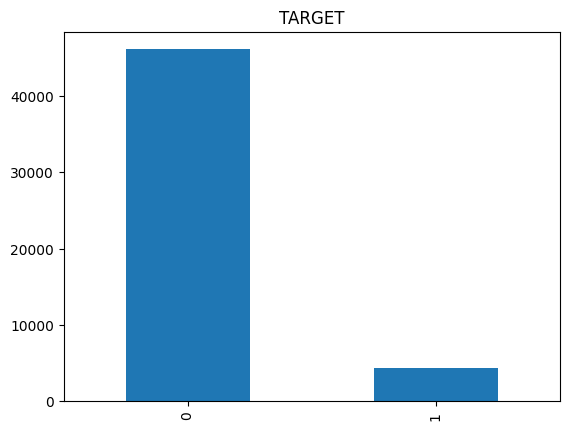

In [ ]:
if split_flag:
    print_imbalance(x_test,y_test,"Test before resampling",convert=False)

### resampling

In [ ]:
# pip install imbalanced-learn это надо вбить в терминал
# ===============================================================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Тут делаем наш resampling
# ===============================================================
if imbalance_flag:
    resampling = RandomUnderSampler(random_state=0,sampling_strategy='majority')
    # resampling = SMOTE(random_state=0,k_neighbors=3,sampling_strategy='minority',n_jobs=-1)
    x_train, y_train = resampling.fit_resample(x_train, y_train)
    del resampling
    gc.collect()

Train after resampling
Number of rows: 34948
Number with TARGET: 17474
Number without TARGET: 17474
Proportion: 1.0 : 1
Percent: 50.0% : 50.0%


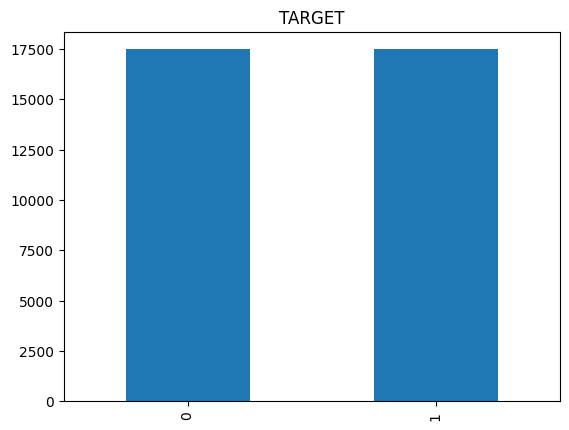

In [ ]:
if imbalance_flag:
    print_imbalance(x_train,y_train,"Train after resampling",convert=False)
else:
    print(f"imbalance_flag - {imbalance_flag}")
    print('ничего не делалось для решения проблемы дисбаланса')

Test после resampling(не изменился)
Number of rows: 50427
Number with TARGET: 4360
Number without TARGET: 46067
Proportion: 10.57 : 1
Percent: 91.4% : 8.6%


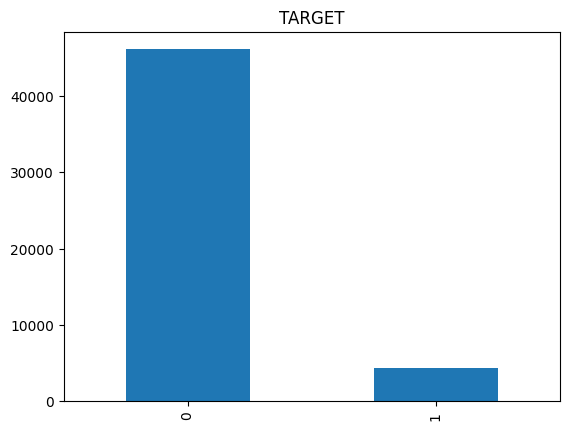

In [ ]:
if imbalance_flag and split_flag:
    print_imbalance(x_test,y_test,"Test после resampling(не изменился)", convert=False)

## Feature Selection

### Variance threshold

In [ ]:
if feature_selection_flag:
    print('--------------before--------------')
    print(f"x_train - {x_train.shape}")
    if split_flag:
        print(f"x_test - {x_test.shape}")
    print(f"real_test - {real_test.shape}")
    print()

    from sklearn.feature_selection import VarianceThreshold
    sel = VarianceThreshold(threshold=0)
    sel.fit(x_train)

    x_train = x_train.iloc[:,list(sel.get_support())]
    real_test = real_test.iloc[:,list(sel.get_support())]
    if split_flag:
        x_test = x_test.iloc[:,list(sel.get_support())]

    print('--------------after--------------')
    print(f"x_train - {x_train.shape}")
    if split_flag:
        print(f"x_test - {x_test.shape}")
    print(f"real_test - {real_test.shape}")

--------------before--------------
x_train - (34948, 248)
x_test - (50427, 248)
real_test - (48744, 248)

--------------after--------------
x_train - (34948, 238)
x_test - (50427, 238)
real_test - (48744, 238)


### Removing quasi-constant features

In [ ]:
if feature_selection_flag:
    print('--------------before--------------')
    print(f"x_train - {x_train.shape}")
    if split_flag:
        print(f"x_test - {x_test.shape}")
    print(f"real_test - {real_test.shape}")
    print()

    from sklearn.feature_selection import VarianceThreshold
    sel = VarianceThreshold(threshold=0.01)
    sel.fit(x_train)

    x_train = x_train.iloc[:,list(sel.get_support())]
    real_test = real_test.iloc[:,list(sel.get_support())]
    if split_flag:
        x_test = x_test.iloc[:,list(sel.get_support())]

    print('--------------after--------------')
    print(f"x_train - {x_train.shape}")
    if split_flag:
        print(f"x_test - {x_test.shape}")
    print(f"real_test - {real_test.shape}")

--------------before--------------
x_train - (34948, 238)
x_test - (50427, 238)
real_test - (48744, 238)

--------------after--------------
x_train - (34948, 164)
x_test - (50427, 164)
real_test - (48744, 164)


### Align

In [ ]:
if feature_selection_flag:
    print('--------------before--------------')
    print(f"x_train - {x_train.shape}")
    if split_flag:
        print(f"x_test - {x_test.shape}")
    print(f"real_test - {real_test.shape}")
    print()


    x_train, real_test = x_train.align(real_test, join = 'inner', axis = 1)

    if split_flag:
        x_train, x_test = x_train.align(x_test, join = 'inner', axis = 1)
        x_test, real_test = x_test.align(real_test, join = 'inner', axis = 1)


    print('--------------after--------------')
    print(f"x_train - {x_train.shape}")
    if split_flag:
        print(f"x_test - {x_test.shape}")
    print(f"real_test - {real_test.shape}")
    print()

--------------before--------------
x_train - (34948, 164)
x_test - (50427, 164)
real_test - (48744, 164)

--------------after--------------
x_train - (34948, 164)
x_test - (50427, 164)
real_test - (48744, 164)



## Scaling

In [ ]:
if scaling:
    from sklearn.preprocessing import StandardScaler

    # Median imputation of missing values
    scaler = StandardScaler()
    # Fit on the training data
    scaler.fit(x_train)
    # Transform both training and testing data

    x_train[:] = scaler.transform(x_train)

    real_test[:] = scaler.transform(real_test)
    if split_flag:
        x_test[:] = scaler.transform(x_test)

# Modeling

## function

In [ ]:
# functions
def evaluate_metrics(x_test, y_test,model):
    """
    Считает метрики
    """
    from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
    # Predict Test Data
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm  = confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'cm':cm}

def print_metrics(x, y, model, label=""):
    """
    Функция которую я использую для вывода оценок той или иной модели, тут всякие Accuracy и подобное просто каждый раз
    писать один и тот же код не удобно
    """
    metrics = evaluate_metrics(x,y,model)
    if label is "":
        from re import  split
        label = split(r'\(', str(model))[0]

    print(f'Model: ' + "\033[1m" + label + "\033[0m")
    print(f"Accuracy_score: {metrics['acc']}")
    print(f"Precision_score: {metrics['prec']}")
    print(f"Recall_score: {metrics['rec']}")
    print(f"F1-score: {metrics['f1']}")

    print(f"percentage of type 2 error: {round(metrics['cm'][1][0]/np.sum(metrics['cm']),3)*100}%")

    plt.figure(figsize = (4, 3))

    ax = sns.heatmap(metrics['cm']/np.sum(metrics['cm']), annot=True, cmap='PuRd', fmt='.2%')

    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    # Ticket labels - List must be in alphabetical order
    # ax.xaxis.set_ticklabels([f'No {y.name}',y.name])
    # ax.yaxis.set_ticklabels([f'No {y.name}',y.name])

    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    # Display the visualization of the Confusion Matrix.
    plt.show()

## Preliminary actions

In [ ]:
# создаем папку для результатов
list_of_files = os.listdir()
path = '/content/results/'
if 'results' not in list_of_files:
    os.makedirs('/content/results')

models_arr = []

In [ ]:
print('--------------shapes of train_test_split-------------')
print(f"x_train.shape - {x_train.shape}")
print()
print(f"y_train.shape - {y_train.shape}")

if split_flag:
    print()
    print(f"x_test.shape - {x_test.shape}")
    print()
    print(f"y_test.shape - {y_test.shape}")

--------------shapes of train_test_split-------------
x_train.shape - (34948, 164)

y_train.shape - (34948,)

x_test.shape - (50427, 164)

y_test.shape - (50427,)


## Logistic regression

## LightGBM

## Knn

## SVM

## Decision tree

In [ ]:

from sklearn.tree import DecisionTreeClassifier

# Make the random forest classifier
dt = DecisionTreeClassifier(random_state = 50)

# Train on the training data
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=50)

Model: Decision tree on test
Accuracy_score: 0.5897832510361513
Precision_score: 0.12000744809608044
Recall_score: 0.5912844036697248
F1-score: 0.19952016097825245
percentage of type 2 error: 3.5000000000000004%


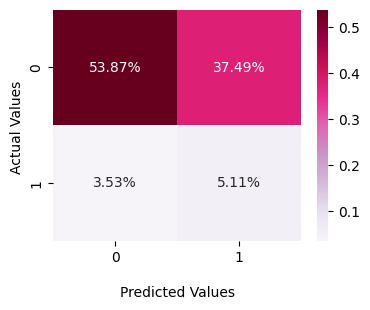

Model: Decision tree on train
Accuracy_score: 1.0
Precision_score: 1.0
Recall_score: 1.0
F1-score: 1.0
percentage of type 2 error: 0.0%


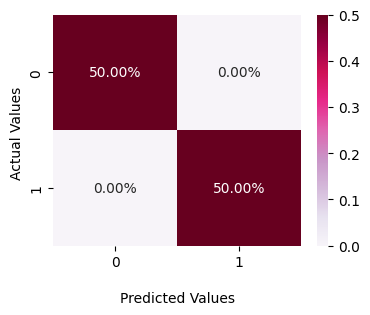

In [ ]:
if split_flag:
    models_arr.append(dt)
    print_metrics(x_test,y_test , dt,'Decision tree on test')
    print_metrics(x_train,y_train , dt,'Decision tree on train')

In [ ]:
if imputer_flag:
    # Make predictions
    # Make sure to select the second column only
    predictions = dt.predict_proba(real_test)[:, 1]

    submit['TARGET'] = predictions
    submit.to_csv(path + 'decision_tree.csv', index = False)

    submit.head()

In [ ]:
df.head

<bound method NDFrame.head of        SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          100001         Cash loans           F            N               Y   
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N  

In [ ]:
# Importing the necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Load the Home Credit dataset
# Replace 'path_to_dataset' with the actual path to your dataset
df = pd.read_csv('data/application_test.csv')

# Separate the features and target variable
# Replace 'target_column' with the name of your target column in the dataset
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Create a decision tree classifier with a maximum depth
clf = DecisionTreeClassifier(max_depth=3)

# Fit the classifier to the data
clf.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=True)
plt.show()


KeyError: ignored

## Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.6s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.3s finished


Model: Random Forest on test
Accuracy_score: 0.6786047157276855
Precision_score: 0.16697588126159554
Recall_score: 0.6811926605504587
F1-score: 0.26820788368627807
percentage of type 2 error: 2.8000000000000003%


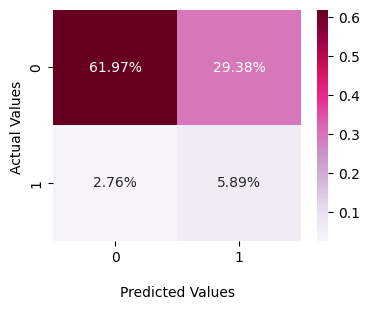

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished


Model: Random Forest on train
Accuracy_score: 1.0
Precision_score: 1.0
Recall_score: 1.0
F1-score: 1.0
percentage of type 2 error: 0.0%


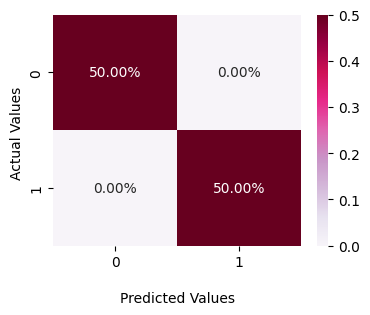

In [ ]:
if split_flag:
    models_arr.append(rf)
    print_metrics(x_test,y_test , rf,'Random Forest on test')
    print_metrics(x_train,y_train , rf,'Random Forest on train')

In [ ]:
if imputer_flag:
    # Make predictions
    # Make sure to select the second column only
    predictions = rf.predict_proba(real_test)[:, 1]

    submit['TARGET'] = predictions
    submit.to_csv(path + 'random_forest.csv', index = False)

    submit.head()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished


## Naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create the Gaussian Naive Bayes classifier
nb = GaussianNB()

# Train on the training data
nb.fit(x_train, y_train)


GaussianNB()

Model: Gaussian Naive Bayes classifier on test
Accuracy_score: 0.37616752929977987
Precision_score: 0.10757110583328507
Recall_score: 0.8518348623853211
F1-score: 0.19101990433575064
percentage of type 2 error: 1.3%


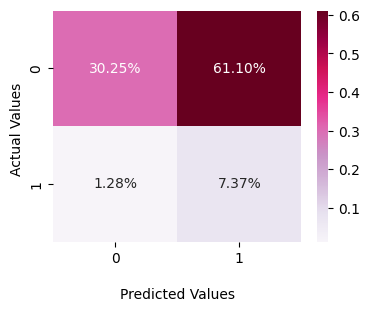

Model: Gaussian Naive Bayes classifier on train
Accuracy_score: 0.5966865056655603
Precision_score: 0.5637378805598521
Recall_score: 0.8551562321162871
F1-score: 0.6795207021213706
percentage of type 2 error: 7.199999999999999%


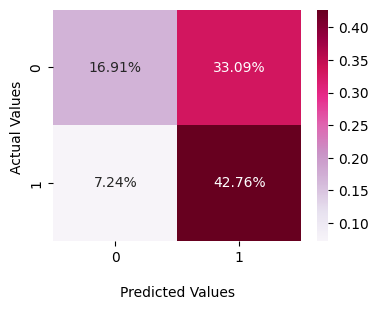

In [ ]:
if split_flag:
    models_arr.append(nb)
    print_metrics(x_test,y_test , nb,'Gaussian Naive Bayes classifier on test')
    print_metrics(x_train,y_train , nb,'Gaussian Naive Bayes classifier on train')

# Results

### create zip file

In [ ]:
import shutil
shutil.make_archive('result', 'zip', path)

'/content/result.zip'

### Roc-Auc

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.5s finished


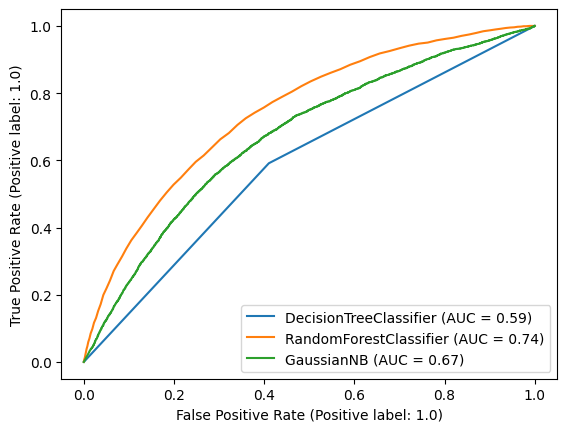

In [ ]:
if split_flag:
    from sklearn.metrics import RocCurveDisplay
    ax = plt.gca()
    for i in models_arr:
        RocCurveDisplay.from_estimator(i, x_test, y_test, ax=ax)

    plt.show()